In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm import cross_validation

# Import LightFM's evaluation metrics
from lightfm.evaluation import precision_at_k as lightfm_prec_at_k
from lightfm.evaluation import recall_at_k as lightfm_recall_at_k

C:\Users\Yurov\anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [127]:
# default number of recommendations
K = 10
# percentage of data used for testing
TEST_PERCENTAGE = 0.25
# model learning rate
LEARNING_RATE = 0.25
# no of latent factors
NO_COMPONENTS = 20
# no of epochs to fit model
NO_EPOCHS = 5

# regularisation for both user and item features
ITEM_ALPHA=1e-6
USER_ALPHA=1e-6

# seed for pseudonumber generations
SEEDNO = 321

In [14]:
data = pd.read_csv('data/hobbies/pupil_info.csv', sep=';')

In [15]:
data.drop(columns='Unnamed: 0', inplace=True)
data.columns = ['name', 'userID', 'state', 'age', 'sex']

In [16]:
data.head()

,name,userID,state,age,sex
0,NaN,22941.0,1.0,12.0,Мужской
1,NaN,22886.0,1.0,13.0,Женский
2,NaN,22859.0,1.0,14.0,Женский
3,NaN,22951.0,1.0,12.0,Женский
4,NaN,22956.0,1.0,12.0,Женский


In [17]:
names = {v: i for i, v in enumerate(data['name'].unique())}
data['nameID'] = data['name'].map(names)

In [18]:
data = data[data['name'].notna()][['userID','nameID','state','age','sex']]

In [19]:
data.head()

,userID,nameID,state,age,sex
4433,1603634.0,1,1.0,9.0,Женский
4434,1257456.0,1,1.0,17.0,Мужской
4435,1262813.0,2,1.0,37.0,Мужской
4436,1262783.0,2,1.0,37.0,Мужской
4437,1262818.0,2,1.0,40.0,Мужской


In [20]:
dataset = Dataset()

In [21]:
dataset.fit(users=data['userID'], items=data['nameID'])
dataset.interactions_shape()

(158470, 373)

Next is to build the interaction matrix. The `build_interactions` method returns 2 COO sparse matrices, namely the `interactions` and `weights` matrices.

In [22]:
%%time
(interactions, weights) = dataset.build_interactions(data.iloc[:, 0:3].values)

Wall time: 661 ms


LightLM works slightly differently compared to other packages as it expects the train and test sets to have same dimension. Therefore the conventional train test split will not work.

The package has included the `cross_validation.random_train_test_split` method to split the interaction data and splits it into two disjoint training and test sets. 

However, note that **it does not validate the interactions in the test set to guarantee all items and users have historical interactions in the training set**. Therefore this may result into a partial cold-start problem in the test set.

In [23]:
train_interactions, test_interactions = cross_validation.random_train_test_split(interactions, test_percentage=TEST_PERCENTAGE, random_state=np.random.RandomState(SEEDNO))

Double check the size of both the train and test sets.

In [24]:
print(f"Shape of train interactions: {train_interactions.shape}")
print(f"Shape of test interactions: {test_interactions.shape}")

Shape of train interactions: (158470, 373)
Shape of test interactions: (158470, 373)


### 2.4 Fit the LightFM model

In this notebook, the LightFM model will be using the weighted Approximate-Rank Pairwise (WARP) as the loss. Further explanation on the topic can be found [here](https://making.lyst.com/lightfm/docs/examples/warp_loss.html#learning-to-rank-using-the-warp-loss).


In general, it maximises the rank of positive examples by repeatedly sampling negative examples until a rank violation has been located. This approach is recommended when only positive interactions are present.

In [25]:
model1 = LightFM(loss='warp', no_components=NO_COMPONENTS, learning_rate=LEARNING_RATE, random_state=np.random.RandomState(SEEDNO))

In [26]:
%%time
model1.fit(interactions=train_interactions, verbose=True, epochs=NO_EPOCHS)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Wall time: 1.7 s


Before we can evaluate the fitted model and to get the data into a format which is compatible with the existing evaluation methods within this repo, the data needs to be massaged slightly.

First the train/test indices need to be extracted from the `lightfm.cross_validation` method as follows:

In [27]:
uids, iids, interaction_data = cross_validation._shuffle(interactions.row, interactions.col, interactions.data, random_state=np.random.RandomState(SEEDNO))

cutoff = int((1.0 - TEST_PERCENTAGE) * len(uids))
test_idx = slice(cutoff, None)

In [28]:
test_idx

slice(144718, None, None)

Then the the mapping between internal and external representation of the user and item are extracted as follows:

In [31]:
uid_map, ufeature_map, iid_map, ifeature_map = dataset.mapping()

Once the train/test indices and mapping are ready, the test dataframe can be constructed as follows:

In [34]:
def prepare_test_df(test_idx, uids, iids, uid_map, iid_map, weights):
    """Function to prepare test df for evaluation

    Args:
        test_idx (slice): slice of test indices
        uids (np.array): Array of internal user indices
        iids (np.array): Array of internal item indices
        uid_map (dict): Keys to map internal user indices to external ids.
        iid_map (dict): Keys to map internal item indices to external ids.
        weights (np.float32 coo_matrix): user-item interaction

    Returns:
        pd.DataFrame: user-item selected for testing
    """
    test_df = pd.DataFrame(
        zip(
            uids[test_idx],
            iids[test_idx],
            [list(uid_map.keys())[x] for x in uids[test_idx]],
            [list(iid_map.keys())[x] for x in iids[test_idx]],
        ),
        columns=["uid", "iid", "userID", "itemID"],
    )

    dok_weights = weights.todok()
    test_df["rating"] = test_df.apply(lambda x: dok_weights[x.uid, x.iid], axis=1)

    return test_df[["userID", "itemID", "rating"]]

In [35]:
%%time
test_df = prepare_test_df(test_idx, uids, iids, uid_map, iid_map, weights)

Wall time: 2min 35s


In [38]:
test_df.sample(5)

,userID,itemID,rating
22050,888384.0,92,1.0
18617,379191.0,92,1.0
9165,750442.0,293,1.0
34263,786716.0,143,1.0
31374,1570848.0,286,1.0


In addition, the predictions of all unseen user-item pairs (e.g. removing those seen in the training data) can be prepared as follows:

In [39]:
def prepare_all_predictions(
    data,
    uid_map,
    iid_map,
    interactions,
    model,
    num_threads,
    user_features=None,
    item_features=None,
):
    """Function to prepare all predictions for evaluation.
    
    Args:
        data (pandas df): dataframe of all users, items and ratings as loaded
        uid_map (dict): Keys to map internal user indices to external ids.
        iid_map (dict): Keys to map internal item indices to external ids.
        interactions (np.float32 coo_matrix): user-item interaction
        model (LightFM instance): fitted LightFM model
        num_threads (int): number of parallel computation threads
        user_features (np.float32 csr_matrix): User weights over features 
        item_features (np.float32 csr_matrix):  Item weights over features

    Returns:
        pd.DataFrame of all predictions
    """
    users, items, preds = [], [], []
    item = list(data.itemID.unique())
    for user in data.userID.unique():
        user = [user] * len(item)
        users.extend(user)
        items.extend(item)

    all_predictions = pd.DataFrame(data={"userID": users, "itemID": items})
    all_predictions["uid"] = all_predictions.userID.map(uid_map)
    all_predictions["iid"] = all_predictions.itemID.map(iid_map)

    dok_weights = interactions.todok()
    all_predictions["rating"] = all_predictions.apply(
        lambda x: dok_weights[x.uid, x.iid], axis=1
    )

    all_predictions = all_predictions[all_predictions.rating < 1].reset_index(drop=True)
    all_predictions = all_predictions.drop("rating", axis=1)

    all_predictions["prediction"] = all_predictions.apply(
        lambda x: model.predict(
            user_ids=x["uid"],
            item_ids=[x["iid"]],
            user_features=user_features,
            item_features=item_features,
            num_threads=num_threads,
        )[0],
        axis=1,
    )

    return all_predictions[["userID", "itemID", "prediction"]]

In [42]:
data['itemID'] = data['nameID']

In [46]:
%%time
all_predictions = prepare_all_predictions(data, uid_map, iid_map, interactions=test_interactions, model=model1, num_threads=50)

KeyboardInterrupt: 

In [47]:
all_predictions.sample(5)

NameError: name 'all_predictions' is not defined

In [48]:
%%time
eval_precision_lfm = lightfm_prec_at_k(model1, test_interactions, train_interactions, k=K).mean()
eval_recall_lfm = lightfm_recall_at_k(model1, test_interactions, train_interactions, k=K).mean()

Wall time: 2.28 s


In [49]:
eval_precision_lfm, eval_recall_lfm

(0.04483372, 0.43053849303849306)

In [56]:
model1.predict([142], [122, 5, 44])

array([ 7.3910017 , -0.18388423,  1.51205826])

## 3. Movie recommender with LightFM using explicit feedbacks and additional item and user features

As the LightFM was designed to incorporates both user and item metadata, the model can be extended to include additional features such as movie genres and user occupations.

### 3.1 Extract and prepare movie genres

In this notebook, the movie's genres will be used as the item metadata. As the genres have already been loaded during the initial data import, it can be processed directly as follows:

In [110]:
data = data.join(pd.get_dummies(data['sex']))

In [111]:
data.head()

,userID,nameID,state,age,sex,itemID,Женский,Мужской
4433,1603634.0,1,1.0,9.0,Женский,1,1,0
4434,1257456.0,1,1.0,17.0,Мужской,1,0,1
4435,1262813.0,2,1.0,37.0,Мужской,2,0,1
4436,1262783.0,2,1.0,37.0,Мужской,2,0,1
4437,1262818.0,2,1.0,40.0,Мужской,2,0,1


In [117]:
# user_feat = data[['age', 'Женский', 'Мужской']].values.tolist()
user_feat = sorted(list(set(data[['age', 'Женский', 'Мужской']])))
user_feat

['age', 'Женский', 'Мужской']

In [118]:
%%time
dataset2 = Dataset()
dataset2.fit(data['userID'], 
            data['nameID'], 
            #item_features=all_movie_genre,
            user_features=user_feat)

Wall time: 247 ms


The movie genres are then converted into a item feature matrix using the `build_item_features` method as follows:

In [128]:
# item_features = dataset2.build_item_features((x, y) for x,y in zip(data.itemID, movie_genre))

The user occupations are then converted into an user feature matrix using the `build_user_features` method as follows:

In [124]:
user_features = dataset2.build_user_features((x, [y]) for x,y in zip(data.userID, data[['age', 'Женский', 'Мужской']]))

In [125]:
user_features

<158470x158473 sparse matrix of type '<class 'numpy.float32'>'
	with 158473 stored elements in Compressed Sparse Row format>

Once the item and user features matrices have been completed, the next steps are similar as before, which is to build the interaction matrix and split the interactions into train and test sets as follows:

In [126]:
(interactions2, weights2) = dataset2.build_interactions(data.iloc[:, 0:3].values)

train_interactions2, test_interactions2 = cross_validation.random_train_test_split(interactions2, test_percentage=TEST_PERCENTAGE,random_state=np.random.RandomState(SEEDNO))

### 3.3 Fit the LightFM model with additional user and item features

The parameters of the second model will be similar to the first model to facilitates comparison.

The model performance at each epoch is also tracked by the same metrics as before.

In [129]:
model2 = LightFM(loss='warp', no_components=NO_COMPONENTS, 
                 learning_rate=LEARNING_RATE, 
                 item_alpha=ITEM_ALPHA,
                 user_alpha=USER_ALPHA,
                 random_state=np.random.RandomState(SEEDNO))

The LightFM model can then be fitted:

In [131]:
%%time
model2.fit(interactions=train_interactions2,
           user_features=user_features,
#            item_features=item_features,
           epochs=NO_EPOCHS);

Wall time: 1.75 s


### 3.4 Prepare model evaluation data

Similar to the previous model, the evaluation data needs to be prepared in order to get them into a format consumable with this repo's evaluation methods.

Firstly the train/test indices and id mappings are extracted using the new interations matrix as follows:

In [132]:
uids, iids, interaction_data = cross_validation._shuffle(
    interactions2.row, interactions2.col, interactions2.data, 
    random_state=np.random.RandomState(SEEDNO))

uid_map, ufeature_map, iid_map, ifeature_map = dataset2.mapping()

The test dataframe is then constructed as follows:

In [133]:
%%time
test_df2 = prepare_test_df(test_idx, uids, iids, uid_map, iid_map, weights2)

Wall time: 2min 36s


The predictions of all unseen user-item pairs can be prepared as follows:

In [31]:
with Timer() as test_time:
    all_predictions2 = prepare_all_predictions(data, uid_map, iid_map, 
                                              interactions=train_interactions2,
                                               user_features=user_features,
                                               item_features=item_features,
                                               model=model2,
                                               num_threads=NO_THREADS)

print(f"Took {test_time.interval:.1f} seconds for prepare and predict all data.")

Took 274.7 seconds for prepare and predict all data.


In [136]:
%%time
eval_precision_lfm2 = lightfm_prec_at_k(model2, test_interactions2, train_interactions2, k=K, user_features=user_features).mean()
eval_recall_lfm2 = lightfm_recall_at_k(model2, test_interactions2, train_interactions2, k=K, user_features=user_features).mean()

Wall time: 2.27 s


In [137]:
eval_precision_lfm2, eval_recall_lfm2

(0.045184717, 0.4338627588627588)

In [56]:
model1.predict([142], [122, 5, 44])

array([ 7.3910017 , -0.18388423,  1.51205826])

## 4. Evaluate model fitting process

In addition to the inclusion of both implicit and explicit data, the model fitting process can also be monitored in order to determine whether the model is being trained properly. 

This notebook also includes a `track_model_metrics` method which plots the model's metrics e.g. Precision@K and Recall@K as model fitting progresses.

For the first model (using only explicit data), the model fitting progress is shown as follows:

In [143]:
def track_model_metrics(
    model,
    train_interactions,
    test_interactions,
    k=10,
    no_epochs=100,
    no_threads=8,
    show_plot=True,
    **kwargs
):
    """Function to record model's performance at each epoch, formats the performance into tidy format,
    plots the performance and outputs the performance data.

    Args:
        model (LightFM instance): fitted LightFM model
        train_interactions (scipy sparse COO matrix): train interactions set
        test_interactions (scipy sparse COO matrix): test interaction set
        k (int): number of recommendations, optional
        no_epochs (int): Number of epochs to run, optional
        no_threads (int): Number of parallel threads to use, optional 
        **kwargs: other keyword arguments to be passed down
    
    Returns:
        pd.DataFrame: performance traces of the fitted model
        LightFM model: fitted model
        matplotlib axes: side effect of the method
    """
    # initialising temp data storage
    model_prec_train = [0] * no_epochs
    model_prec_test = [0] * no_epochs

    model_rec_train = [0] * no_epochs
    model_rec_test = [0] * no_epochs

    # fit model and store train/test metrics at each epoch
    for epoch in range(no_epochs):
        model.fit_partial(
            interactions=train_interactions, epochs=1, num_threads=no_threads, **kwargs
        )
        model_prec_train[epoch] = precision_at_k(
            model, train_interactions, k=k, **kwargs
        ).mean()
        model_prec_test[epoch] = precision_at_k(
            model, test_interactions, k=k, **kwargs
        ).mean()

        model_rec_train[epoch] = recall_at_k(
            model, train_interactions, k=k, **kwargs
        ).mean()
        model_rec_test[epoch] = recall_at_k(
            model, test_interactions, k=k, **kwargs
        ).mean()

    # collect the performance metrics into a dataframe
    fitting_metrics = pd.DataFrame(
        zip(model_prec_train, model_prec_test, model_rec_train, model_rec_test),
        columns=[
            "model_prec_train",
            "model_prec_test",
            "model_rec_train",
            "model_rec_test",
        ],
    )
    # convert into tidy format
    fitting_metrics = fitting_metrics.stack().reset_index()
    fitting_metrics.columns = ["epoch", "level", "value"]
    # exact the labels for each observation
    fitting_metrics["stage"] = fitting_metrics.level.str.split("_").str[-1]
    fitting_metrics["metric"] = fitting_metrics.level.str.split("_").str[1]
    fitting_metrics.drop(["level"], axis=1, inplace=True)
    # replace the metric keys to improve visualisation
    metric_keys = {"prec": "Precision", "rec": "Recall"}
    fitting_metrics.metric.replace(metric_keys, inplace=True)
    # plots the performance data
    if show_plot == True:
        model_perf_plots(fitting_metrics)
    return fitting_metrics, model

In [145]:
NO_THREADS = 5

In [148]:
from lightfm.evaluation import precision_at_k, recall_at_k

In [152]:
def model_perf_plots(df):
    """Function to plot model performance metrics.

    Args:
        df (pd.DataFrame): Dataframe in tidy format, with ['epoch','level','value'] columns
    
    Returns:
        obj: matplotlib axes
    """
    g = sns.FacetGrid(df, col="metric", hue="stage", col_wrap=2, sharey=False)
    g = g.map(sns.scatterplot, "epoch", "value").add_legend()

Wall time: 40.8 s


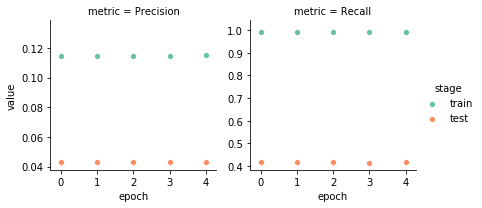

In [153]:
%%time
output1, _ = track_model_metrics(model=model1, train_interactions=train_interactions, 
                              test_interactions=test_interactions, k=K,
                              no_epochs=NO_EPOCHS, no_threads=NO_THREADS)

The second model (with both implicit and explicit data) fitting progress:

Wall time: 42.5 s


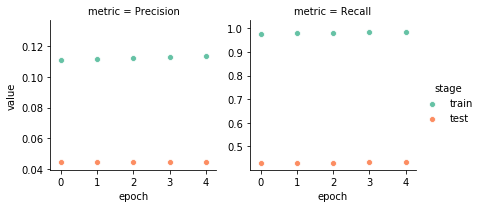

In [154]:
%%time
output2, _ = track_model_metrics(model=model2, train_interactions=train_interactions2, 
                              test_interactions=test_interactions2, k=K,
                              no_epochs=NO_EPOCHS, no_threads=NO_THREADS, 
#                               item_features=item_features,
                              user_features=user_features)

These show slightly different behaviour with the two approaches, the reader can then tune the hyperparameters to improve the model fitting process.


### 4.1 Performance comparison

In addition, the model's performance metrics (based on the test dataset) can be plotted together to facilitate easier comparison as follows:

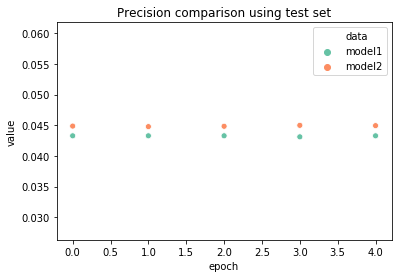

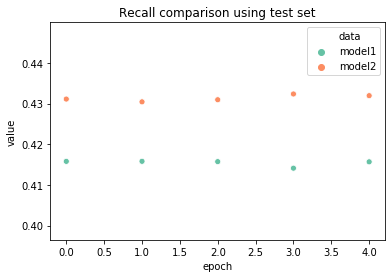

In [155]:
for i in ['Precision', 'Recall']:
    sns.set_palette("Set2")
    plt.figure()
    sns.scatterplot(x="epoch", y="value", hue='data',
                data=compare_metric(df_list = [output1, output2], metric=i)
               ).set_title(f'{i} comparison using test set');

Referring to the figures above, it is rather obvious that the number of epochs is too low as the model's performances have not stabilised. Reader can decide on the number of epochs and other hyperparameters to adjust suit the application.

As stated previously, it is interesting to see model2 (using both implicit and explicit data) performed consistently better than model1 (using only explicit ratings). 

## 5. Similar users and items

As the LightFM package operates based on latent embeddings, these can be retrieved once the model has been fitted to assess user-user and/or item-item affinity.

### 5.1 User affinity

The user-user affinity can be retrieved with the `get_user_representations` method from the fitted model as follows:

In [156]:
_, user_embeddings = model2.get_user_representations(features=user_features)
user_embeddings

array([[ 0.5831387 ,  1.3970304 , -0.49529207, ...,  0.19269472,
         0.45053095,  0.76534486],
       [-0.02635439,  1.1549677 ,  0.26881152, ...,  2.2024467 ,
        -0.30121988,  0.95511943],
       [-0.7535503 ,  0.47379607,  0.6375725 , ...,  2.0539002 ,
         0.30322528,  1.493062  ],
       ...,
       [-1.3905605 ,  0.08818677, -4.20069   , ...,  0.12174738,
         1.3245466 , -1.858634  ],
       [-1.9492089 ,  2.0983686 , -1.4516907 , ...,  2.8870804 ,
         2.4178457 , -1.5501271 ],
       [-1.0118871 ,  0.95851165, -1.7011917 , ...,  0.41770843,
         1.0440892 , -0.9837494 ]], dtype=float32)

In order to retrieve the top N similar users, we can use the `similar_users` from `reco_utils`. For example, if we want to choose top 10 users most similar to the user 1:

In [158]:
def similar_users(user_id, user_features, model, N=10):
    """Function to return top N similar users based on https://github.com/lyst/lightfm/issues/244#issuecomment-355305681

     Args:
        user_id (int): id of user to be used as reference
        user_features (scipy sparse CSR matrix): user feature matric
        model (LightFM instance): fitted LightFM model 
        N (int): Number of top similar users to return
    
    Returns:
        pd.DataFrame: top N most similar users with score
    """
    _, user_representations = model.get_user_representations(features=user_features)

    # Cosine similarity
    scores = user_representations.dot(user_representations[user_id, :])
    user_norms = np.linalg.norm(user_representations, axis=1)
    user_norms[user_norms == 0] = 1e-10
    scores /= user_norms

    best = np.argpartition(scores, -(N + 1))[-(N + 1) :]
    return pd.DataFrame(
        sorted(zip(best, scores[best] / user_norms[user_id]), key=lambda x: -x[1])[1:],
        columns=["userID", "score"],
    )

In [159]:
similar_users(user_id=1, user_features=user_features, 
            model=model2)

,userID,score
0,122258,0.839342
1,20778,0.834042
2,128410,0.824593
3,49146,0.824084
4,122266,0.813177
5,51944,0.811396
6,4023,0.810919
7,98974,0.810549
8,126845,0.804955
9,20404,0.803210


### 5.2 Item affinity

Similar to the user affinity, the item-item affinity can be retrieved with the `get_item_representations` method using the fitted model.

In [160]:
_, item_embeddings = model2.get_item_representations(features=item_features)
item_embeddings

NameError: name 'item_features' is not defined

The function to retrieve the top N similar items is similar to similar_users() above. For example, if we want to choose top 10 items most similar to the item 10:

In [161]:
def similar_items(item_id, item_features, model, N=10):
    """Function to return top N similar items
    based on https://github.com/lyst/lightfm/issues/244#issuecomment-355305681

    Args:
        item_id (int): id of item to be used as reference
        item_features (scipy sparse CSR matrix): item feature matric
        model (LightFM instance): fitted LightFM model 
        N (int): Number of top similar items to return
    
    Returns:
        pd.DataFrame: top N most similar items with score
    """
    _, item_representations = model.get_item_representations(features=item_features)

    # Cosine similarity
    scores = item_representations.dot(item_representations[item_id, :])
    item_norms = np.linalg.norm(item_representations, axis=1)
    item_norms[item_norms == 0] = 1e-10
    scores /= item_norms

    best = np.argpartition(scores, -(N + 1))[-(N + 1) :]
    return pd.DataFrame(
        sorted(zip(best, scores[best] / item_norms[item_id]), key=lambda x: -x[1])[1:],
        columns=["itemID", "score"],
    )

In [162]:
similar_items(item_id=10, item_features=item_features, 
            model=model2)

NameError: name 'item_features' is not defined